# Notebook para la registración de la distribución de dosis 2D medida (film) con la distribución de dosis de referencia (planificada)

In [1]:
import pydicom
import cv2
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, fixed

In [3]:
def resample(image, reference_image, transform):
    
    #interpolator = sitk.sitkLinear # cambiar por primeros vecinos
    interpolator = sitk.sitkNearestNeighbor
    default_value = 0.0
    return sitk.Resample(image, reference_image, transform, interpolator, default_value)

#Samplea imagen 'reference_image' en 'image'

def affine_scale_and_translate(image, reference_image, scale, x_translation, y_translation):
    
    transform = sitk.AffineTransform(2)
    matrix = np.array(transform.GetMatrix()).reshape((2,2))
    image_width = image.GetWidth()
    image_height = image.GetHeight()
    
    matrix[0,0] = scale # modificar la matriz de forma tal que el escalamiento se haga desde el centro en lugar del vertice
    matrix[1,1] = scale
    transform.SetMatrix(matrix.ravel())
    #transform.SetTranslation((-1*x_translation+scale*image_width,y_translation+scale*image_height))
    transform.SetTranslation((-1*x_translation,y_translation))
    return resample(image, reference_image, transform)
      
#Define la transformacion 'transform' a partir de la traslacion en x, en y y el scale y
    
# esta funcion recibe imagenes y grafica. Sería conveniente que devuelva una imagen y que el graficado se haga afuera
# pero me parece que no es posible dado que está dentro de un interact 
def display_images_with_alpha(x_translation, y_translation, scale, alpha, color_limits, fixed_img, moving_img, reference_image):
    
    moving_img = affine_scale_and_translate(moving_img, reference_image, scale, x_translation, y_translation)
    
    img = (1.0 - alpha)*fixed_img + alpha*moving_img
    
    plt.figure(figsize = (10,10))
    plt.imshow(sitk.GetArrayFromImage(img),cmap=plt.cm.Greys_r);
    #plt.axis('off')
    plt.clim(color_limits[0], color_limits[1])
    plt.show()
    
    return moving_img

def func(netOD, a, b):
    return a*(1.0-np.exp(-1.0*netOD))/(np.exp(-1.0*netOD)-b)

## Carga de las imágenes

In [4]:
# Load dicom 2D distribution (reference image)
plan = pydicom.read_file('C:\Users\Roy\Desktop\Exp4\Archivos\Tailandia\Siriraj\Dose plane_IMRT at 1.5cm_1F\CIRS Phantom IMRT.dcm')
planed_array = plan.pixel_array*plan.DoseGridScaling*100
planed_array = planed_array.astype(np.float32)

planed_size = planed_array.shape
print planed_size
print plan.pixel_array.shape


(256L, 256L)
(256L, 256L)


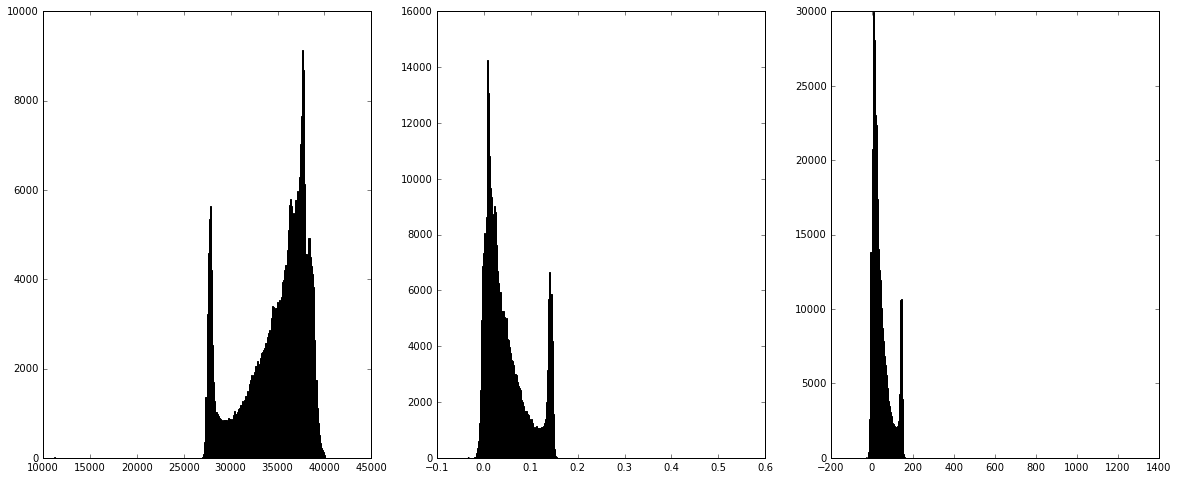

(511L, 598L) 473.68322 0.42664 38460.0


In [5]:
# Load film dosimetry image
film_array = cv2.imread('C:\Users\Roy\Desktop\Exp4\Archivos\Tailandia\Siriraj\siriraj_phantom2.tif',-1)
#film_image_color = sitk.ReadImage('C:\Users\Roy\Desktop\Exp4\Archivos\Tailandia\Chulabhorn Hospital\CCC_phantom001.tif',1)
#film_array = sitk.GetArrayFromImage(film_image_color) # este slicing para sacar el canal rojo, puede hacerse directamente en sitk

film_array = film_array[:,:,2].astype(np.float32) 
#EN OPENCV EL CANAL ROJO ES EL 2

parametros = np.loadtxt('C:\Users\Roy\Desktop\Exp4\Archivos\Tailandia\Siriraj\cal film\parametros(func5).txt',delimiter='\t',usecols=(1,))
data = np.loadtxt('C:\Users\Roy\Desktop\Exp4\Archivos\Tailandia\Siriraj\cal film\dosis_vs_intensidad.txt', skiprows=1)
intensidad_pixel_0 = data[0][1].astype(np.float64)
a = parametros[0]
b = parametros[1]

#Grafica el histograma de la matriz mat_norm_255
fig = plt.figure(figsize = (20,8))

plt.subplot(131)
plt.hist(film_array.ravel(), bins=256, fc='k', ec='k')

film_array = np.log10(intensidad_pixel_0/film_array) #aca esta en densidad optica neta

plt.subplot(132)
plt.hist(film_array.ravel(), bins=256, fc='k', ec='k')

film_array = func(film_array,a,b)

plt.subplot(133)
plt.hist(film_array.ravel(), bins=256, fc='k', ec='k')

plt.show()
film_size = film_array.shape
print film_size,a,b,intensidad_pixel_0

## Grafico las dos imágenes cargadas
Grafico las dos imagenes en escala de grises y con su tamaño original

[0.0, 192.8007]
[0.0, 192.8007]
[-26.414448, 1235.2]


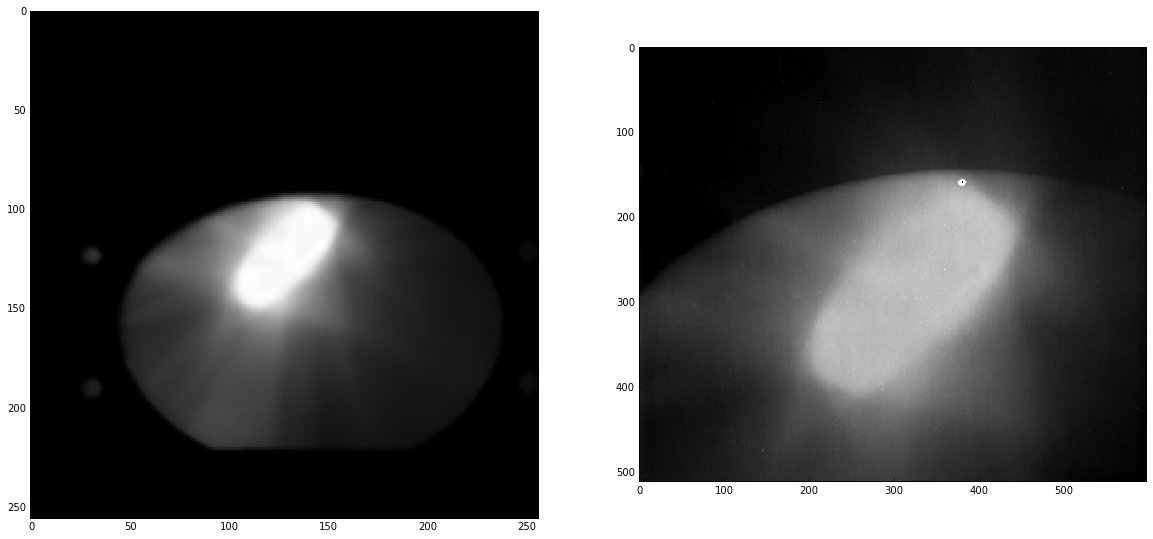

In [6]:
color_limits = [np.amin([planed_array.min(), film_array.min()]), np.amax([planed_array.max(), film_array.max()])]
planed_color_limits = [planed_array.min(), planed_array.max()]
film_color_limits = [film_array.min(), film_array.max()]
color_limits = [planed_array.min(), planed_array.max()]

print color_limits
print planed_color_limits
print film_color_limits

plt.figure(figsize = (20,20))

plt.subplot(121)
plt.imshow(planed_array , cmap = 'gray', interpolation = 'nearest')
#plt.axis('off') # to hide tick values on X and Y axis
plt.clim(color_limits[0],color_limits[1])

plt.subplot(122)
plt.imshow(film_array , cmap = 'gray', interpolation = 'nearest')
#plt.axis('off')
#plt.clim(color_limits[0],color_limits[1])
plt.clim(color_limits[0],color_limits[1])

plt.show()

## Aproximación inicial
Grafico las dos imágenes juntas sobre un array cuyas dimensiones alcance para ambas

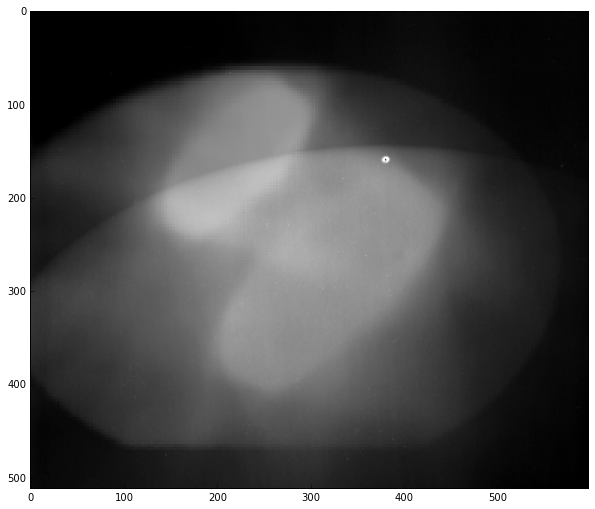

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x000000001114BA80> >

In [7]:
film_image = sitk.GetImageFromArray(film_array)
planed_image = sitk.GetImageFromArray(planed_array)

row_max = np.amax([planed_size[0],film_size[0]]) 
column_max = np.amax([planed_size[1],film_size[1]]) 

canvas_array = np.zeros([row_max,column_max]) # la creacion de esta imagen puede hacerse directamente en sitk
canvas_image = sitk.GetImageFromArray(canvas_array)
canvas_image2 = sitk.Image(3, 3, sitk.sitkUInt16)


affine = sitk.AffineTransform(2)

planed_rsmpld = sitk.Resample(planed_image, canvas_image, affine, sitk.sitkLinear, 0.0, planed_image.GetPixelIDValue())
film_rsmpld = sitk.Resample(film_image, canvas_image, affine, sitk.sitkLinear, 0.0, planed_image.GetPixelIDValue())

planed_rsmpld =  interact(display_images_with_alpha,  x_translation=(-100.0, 100.0), y_translation=(-100.0, 150.0), 
         scale=(0.05, 1.0, 0.005), alpha=(0.0,1.0,0.05), color_limits = fixed(color_limits), fixed_img = fixed(film_rsmpld), 
         moving_img=fixed(planed_rsmpld),reference_image=fixed(canvas_image));

## Registración


TypeError: in method 'GetByteArrayFromImage', argument needs to be of type 'sitk::Image *'

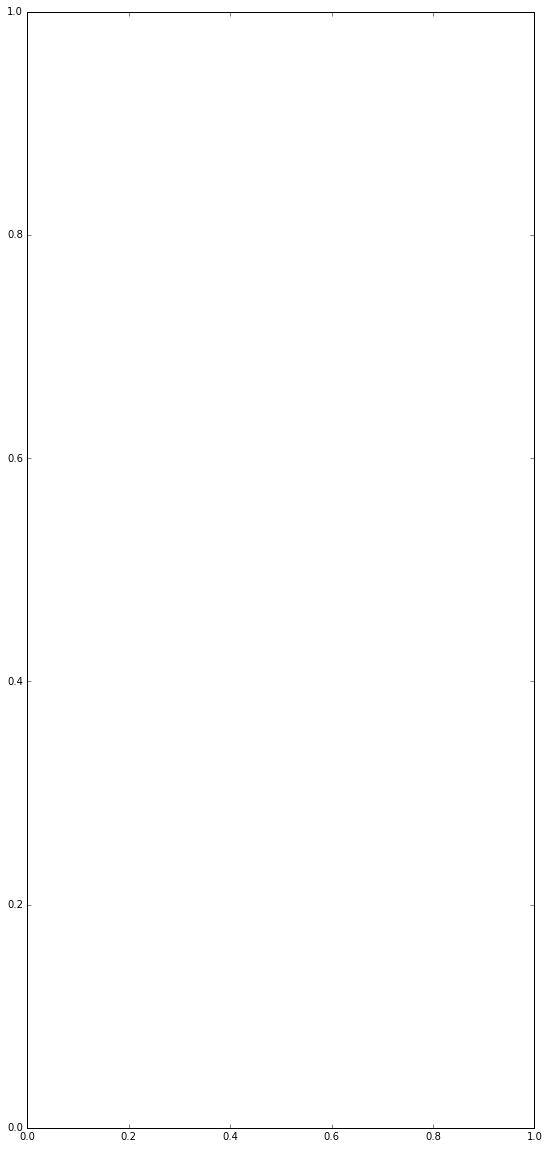

In [17]:
plt.figure(figsize = (20,20))

plt.subplot(121)
plt.imshow(sitk.GetArrayFromImage(planed_rsmpld) , cmap = 'gray', interpolation = 'nearest')
#plt.axis('off') # to hide tick values on X and Y axis
plt.clim(color_limits[0],color_limits[1])

plt.subplot(122)
plt.imshow(sitk.GetArrayFromImage(film_rsmpld) , cmap = 'gray', interpolation = 'nearest')
#plt.axis('off')
plt.clim(color_limits[0],color_limits[1])

plt.show() 
